In [2]:
from support_functions import *
from pedalboard import Chorus, Reverb, Distortion
import numpy as np
import tensorflow as tf
%matplotlib inline

dist = read_proces_dump('data/clean_guitar_large_sample.wav', 
                        'data/distortion_guitar_large_sample.wav', 
                 [Distortion(), Reverb(room_size=0.25)])

Heavily inspired by https://github.com/GuitarML/GuitarLSTM/blob/main/train.py

In [2]:
from keras import Sequential, Model
import keras.layers as layers
import tensorflow as tf
import tensorflow.keras.backend as K

kernel_size=12  # <---- started with 3, from a https://github.com/GuitarML/GuitarLSTM/blob/main/train.py tried 12, but this lead to massive
               #       overfitting
chunk_size = 128    # <--- in this context, probably rename to input size or time window? It is not the same as chunk size in cnn

# Have not really played around with the layers, this 
# architecture is something roughly copied from a paper about
# selfsupervised learning 
# model.add(Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same',input_shape=(input_size,1)))
#     model.add(Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same'))
#     model.add(LSTM(hidden_units))
#     model.add(Dense(1, activation=None))
model = Sequential(
    [
        layers.Conv1D(32, kernel_size=12, strides=4, input_shape=(chunk_size,1), padding='same', activation='relu'),
        layers.Conv1D(32, kernel_size=12, strides=4, padding='same', activation='relu'),
        layers.LSTM(64),
        layers.Dense(1, activation='linear')
    ]
)

# Fancy loss function, optional. Not really sure if it adds anythging as a loss function
def pre_emphasis_filter(x, coeff=0.95):
    return tf.concat([x, x - coeff * x], 1)
    
def error_to_signal(y_true, y_pred): 
    """
    Error to signal ratio with pre-emphasis filter:
    """
    y_true, y_pred = pre_emphasis_filter(y_true), pre_emphasis_filter(y_pred)
    return K.sum(tf.pow(y_true - y_pred, 2), axis=0) / K.sum(tf.pow(y_true, 2), axis=0) + 1e-10

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)   # <---- Needs to be rather low to actually learn anything
model.compile(optimizer=opt, loss='mse', metrics=[error_to_signal])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 32, 32)            416       
                                                                 
 conv1d_1 (Conv1D)           (None, 8, 32)             12320     
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 37,633
Trainable params: 37,633
Non-trainable params: 0
_________________________________________________________________


5509/5509 [==============================] - 10s 2ms/step


<AxesSubplot:>

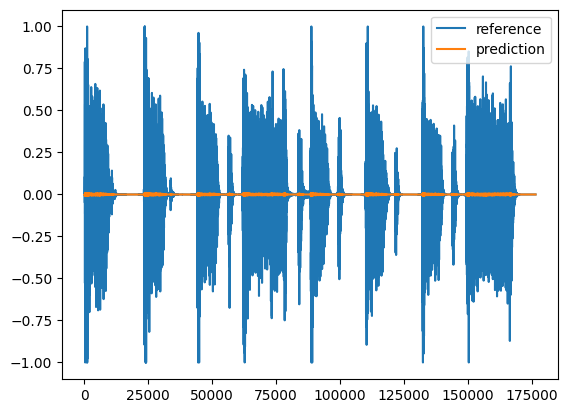

In [89]:
untrained_prediction = model.predict(dist['original'][chunk_size-1:] )   
pd.DataFrame({'reference': dist['original'][chunk_size-1:], 'prediction': untrained_prediction.flatten()}).plot()

In [4]:
from tensorflow.keras.backend import clear_session

# Training loop on chunked data, all data is just too much for my VRAM

no_chunks = 8
chunk_idx = 1
for dist_chunk in np.array_split(dist, no_chunks):
    clear_session()
    print('next chunk: %d/%d' % (chunk_idx, no_chunks))

    # Note that these indices lead to a (datasize, input_size) array where the data
    # is spaced in time. For example for input_size equals nine this becomes:
    # array([[     0,      1,      2, ...,      6,      7,      8],
    #        [     1,      2,      3, ...,      7,      8,      9],
    #        [     2,      3,      4, ...,      8,      9,     10],
    indices = np.arange(chunk_size) + np.arange(len(dist_chunk)-chunk_size+1)[:,np.newaxis] 
    original_signal = tf.gather(dist_chunk['original'],indices) 
    print(original_signal.shape)
    effected_signal = dist_chunk['effected'][chunk_size-1:] 
    print(effected_signal.shape)
    # TODO: possible randommise data order? 
    history = model.fit(original_signal, effected_signal, epochs=10, batch_size=4096, validation_split=0.2)
    chunk_idx += 1

plot_loss(history)

next chunk: 1/8
(1029234, 128)
(1029234,)
Epoch 1/10
202/202 [==============================] - 2s 10ms/step - loss: 0.0210 - error_to_signal: 0.1264 - val_loss: 0.0101 - val_error_to_signal: 0.1278
Epoch 2/10
202/202 [==============================] - 2s 10ms/step - loss: 0.0208 - error_to_signal: 0.1251 - val_loss: 0.0115 - val_error_to_signal: 0.1634
Epoch 3/10
202/202 [==============================] - 2s 10ms/step - loss: 0.0207 - error_to_signal: 0.1245 - val_loss: 0.0101 - val_error_to_signal: 0.1261
Epoch 4/10
202/202 [==============================] - 2s 9ms/step - loss: 0.0205 - error_to_signal: 0.1238 - val_loss: 0.0101 - val_error_to_signal: 0.1282
Epoch 5/10
202/202 [==============================] - 2s 9ms/step - loss: 0.0204 - error_to_signal: 0.1232 - val_loss: 0.0101 - val_error_to_signal: 0.1265
Epoch 6/10
202/202 [==============================] - 2s 9ms/step - loss: 0.0204 - error_to_signal: 0.1228 - val_loss: 0.0101 - val_error_to_signal: 0.1281
Epoch 7/10
202/202 

<ipython-input-4-ac6728b394d1>:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  effected_signal = dist_chunk['effected'][chunk_size-1:]


202/202 [==============================] - 2s 10ms/step - loss: 0.0074 - error_to_signal: 0.1139 - val_loss: 0.0101 - val_error_to_signal: 0.1277
Epoch 2/10
202/202 [==============================] - 2s 9ms/step - loss: 0.0073 - error_to_signal: 0.1127 - val_loss: 0.0102 - val_error_to_signal: 0.1288
Epoch 3/10
202/202 [==============================] - 2s 9ms/step - loss: 0.0073 - error_to_signal: 0.1124 - val_loss: 0.0102 - val_error_to_signal: 0.1324
Epoch 4/10
202/202 [==============================] - 2s 10ms/step - loss: 0.0073 - error_to_signal: 0.1118 - val_loss: 0.0101 - val_error_to_signal: 0.1268
Epoch 5/10
202/202 [==============================] - 2s 9ms/step - loss: 0.0072 - error_to_signal: 0.1113 - val_loss: 0.0101 - val_error_to_signal: 0.1282
Epoch 6/10
202/202 [==============================] - 2s 9ms/step - loss: 0.0072 - error_to_signal: 0.1113 - val_loss: 0.0105 - val_error_to_signal: 0.1388
Epoch 7/10
202/202 [==============================] - 2s 9ms/step - loss:

ResourceExhaustedError: {{function_node __wrapped__GatherV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1029233,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:GatherV2]

small clip to check the prediction:

4688/4688 [==============================] - 10s 2ms/step


<ipython-input-15-e3f08abf776b>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pd.DataFrame({'reference': effected_signal[:max_pred_length], 'prediction': trained_prediction.flatten()}).plot()


<AxesSubplot:>

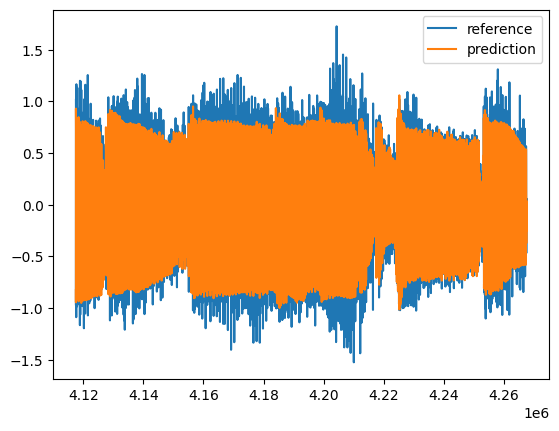

In [15]:
max_pred_length = 150000
trained_prediction = model.predict(original_signal[:max_pred_length])   
pd.DataFrame({'reference': effected_signal[:max_pred_length], 'prediction': trained_prediction.flatten()}).plot()

In [3]:
wav_player('data/clean_guitar_large_sample.wav')

In [16]:
dump_numpy_audio(resize_to_mono(trained_prediction),
                 reference_wav='data/clean_guitar_large_sample.wav',
                 output_wav='data/trained_distortion_guitar_lstm.wav')
wav_player('data/trained_distortion_guitar_lstm.wav')

In [17]:
dump_numpy_audio(resize_to_mono(effected_signal[:max_pred_length]),
                 reference_wav='data/clean_guitar_large_sample.wav',
                 output_wav='data/trained_distortion_guitar_lstm.wav')
wav_player('data/trained_distortion_guitar_lstm.wav')

<ipython-input-17-3fd32d00796c>:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dump_numpy_audio(resize_to_mono(effected_signal[:max_pred_length]),
